c:\Users\mital\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
202/202 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.4443 - val_loss: 0.1588
Epoch 2/50
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1463 - val_loss: 0.1525
Epoch 3/50
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1301 - val_loss: 0.1495
Epoch 4/50
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1367 - val_loss: 0.1501
Epoch 5/50
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1349 - val_loss: 0.1499
Epoch 6/50
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1352 - val_loss: 0.1508
Epoch 7/50
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1336 - val_loss: 0.1499
Epoch 8/50
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1325 - val_loss: 0.1520
Epoch 9/50
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1380 - val_loss: 0.1500
Epoch 10/50
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1375 - val_loss: 0.1533
Epoch 11/50
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1362 - val_loss: 0.1499
Epoch 12/50
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

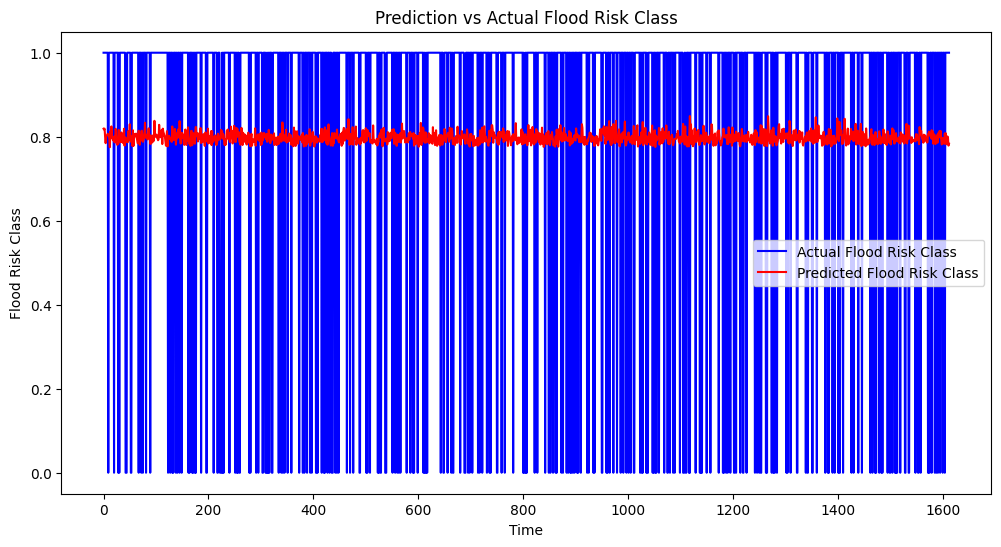

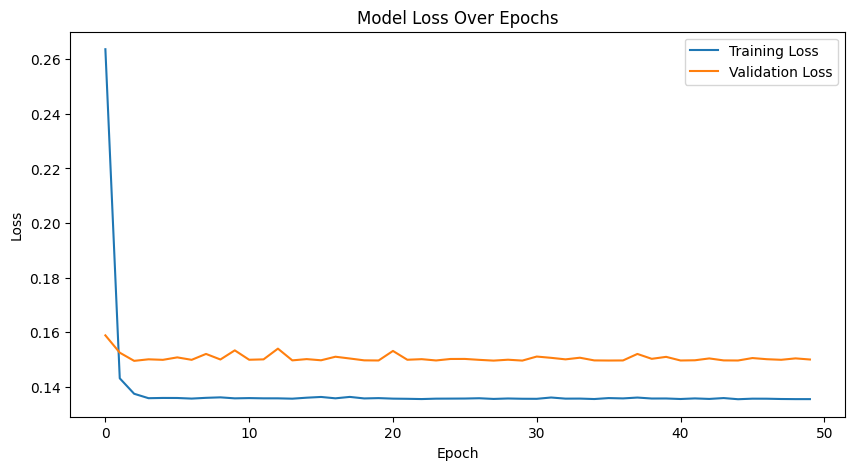

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# Load your data
data = pd.read_csv('flood_data.csv')

# Check for the presence of the Date column and handle accordingly
if 'Date' in data.columns:
    data['Date'] = pd.to_datetime(data['Date'])  # Convert Date column to datetime format
    data.set_index('Date', inplace=True)  # Set Date as index
else:
    print("Warning: 'Date' column not found. Proceeding without date indexing.")
    # Optionally, create a date index based on row number if needed:
    data['Date'] = pd.date_range(start='2020-01-01', periods=len(data), freq='D')
    data.set_index('Date', inplace=True)

# Encode categorical variables if needed (e.g., Area_name)
if 'Area_name' in data.columns:
    data = pd.get_dummies(data, columns=['Area_name'], drop_first=True)

# Encode Flood_Risk_Class as numeric values
if 'Flood_Risk_Class' in data.columns:
    label_encoder = LabelEncoder()
    data['Flood_Risk_Class'] = label_encoder.fit_transform(data['Flood_Risk_Class'])
else:
    raise ValueError("Error: 'Flood_Risk_Class' column is required for predictions.")

# Scaling features
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(data[['Diff_Altitude', 'Water_level', 'flood_level']])
scaled_data = pd.DataFrame(scaled_features, columns=['Diff_Altitude', 'Water_level', 'flood_level'], index=data.index)

# Prepare data for LSTM
X = []
y = []
time_steps = 1  # Set the number of time steps (1 if predicting one step ahead)

for i in range(time_steps, len(scaled_data)):
    X.append(scaled_data.iloc[i-time_steps:i].values)
    y.append(data['Flood_Risk_Class'].iloc[i])

X, y = np.array(X), np.array(y)

# Splitting data into train and test sets
split = int(0.8 * len(X))  # 80% training, 20% testing
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Building the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Making predictions
predictions = model.predict(X_test)

# Plotting Prediction vs Actual
plt.figure(figsize=(12, 6))
plt.plot(y_test, color='blue', label='Actual Flood Risk Class')
plt.plot(predictions, color='red', label='Predicted Flood Risk Class')
plt.xlabel('Time')
plt.ylabel('Flood Risk Class')
plt.title('Prediction vs Actual Flood Risk Class')
plt.legend()
plt.show()

# Optional: Plotting training and validation loss over epochs to check for overfitting
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss Over Epochs')
plt.legend()
plt.show()


Accuracy: 0.82


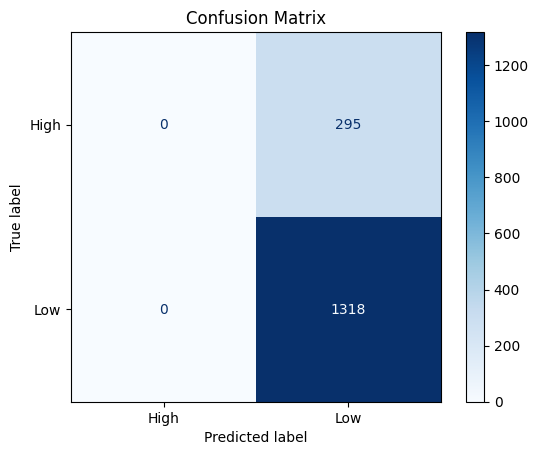

In [4]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Convert predictions to binary classes (0 or 1)
predictions_classes = (predictions > 0.5).astype(int)  # Assuming threshold of 0.5 for binary classification

# Calculate accuracy
accuracy = accuracy_score(y_test, predictions_classes)
print(f'Accuracy: {accuracy:.2f}')

# Confusion Matrix
cm = confusion_matrix(y_test, predictions_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


c:\Users\mital\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\mital\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Precision (Macro): 0.41
Recall (Macro): 0.50
F1 Score (Macro): 0.45
Precision (Weighted): 0.67
Recall (Weighted): 0.82
F1 Score (Weighted): 0.73


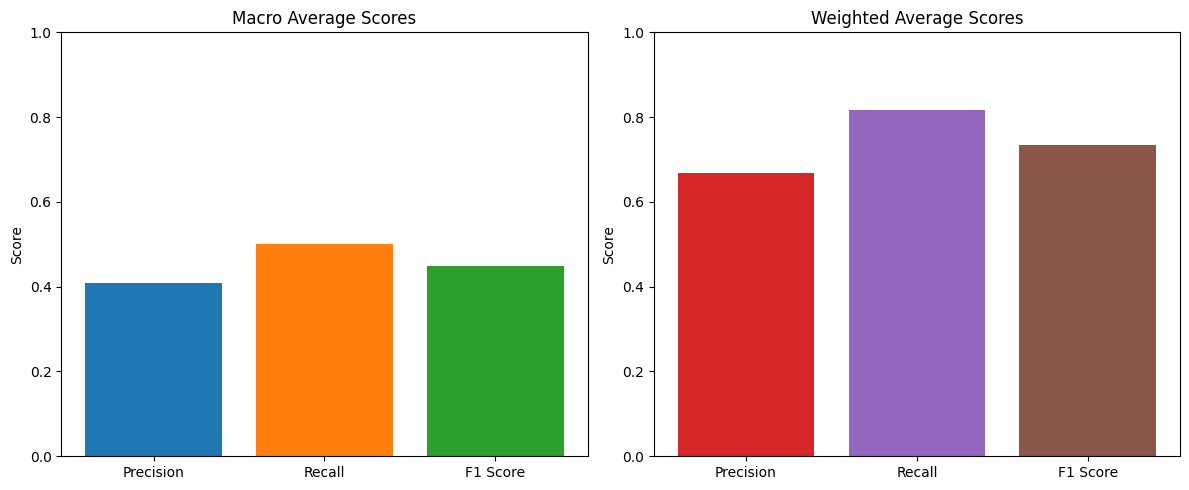

In [5]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

# Assuming y_test and predictions_classes are defined
# Calculate precision, recall, and F1 score
precision_macro = precision_score(y_test, predictions_classes, average='macro')
recall_macro = recall_score(y_test, predictions_classes, average='macro')
f1_macro = f1_score(y_test, predictions_classes, average='macro')

precision_weighted = precision_score(y_test, predictions_classes, average='weighted')
recall_weighted = recall_score(y_test, predictions_classes, average='weighted')
f1_weighted = f1_score(y_test, predictions_classes, average='weighted')

# Display the results
print(f'Precision (Macro): {precision_macro:.2f}')
print(f'Recall (Macro): {recall_macro:.2f}')
print(f'F1 Score (Macro): {f1_macro:.2f}')
print(f'Precision (Weighted): {precision_weighted:.2f}')
print(f'Recall (Weighted): {recall_weighted:.2f}')
print(f'F1 Score (Weighted): {f1_weighted:.2f}')

# Data for plotting
labels = ['Precision', 'Recall', 'F1 Score']
macro_scores = [precision_macro, recall_macro, f1_macro]
weighted_scores = [precision_weighted, recall_weighted, f1_weighted]

# Specify different colors for each bar
macro_colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Blue, Orange, Green
weighted_colors = ['#d62728', '#9467bd', '#8c564b']  # Red, Purple, Brown

# Plotting Macro Scores
plt.figure(figsize=(12, 5))

# Macro Score Plot
plt.subplot(1, 2, 1)
plt.bar(labels, macro_scores, color=macro_colors)
plt.ylim(0, 1)
plt.title('Macro Average Scores')
plt.ylabel('Score')

# Weighted Score Plot
plt.subplot(1, 2, 2)
plt.bar(labels, weighted_scores, color=weighted_colors)
plt.ylim(0, 1)
plt.title('Weighted Average Scores')
plt.ylabel('Score')

plt.tight_layout()
plt.show()


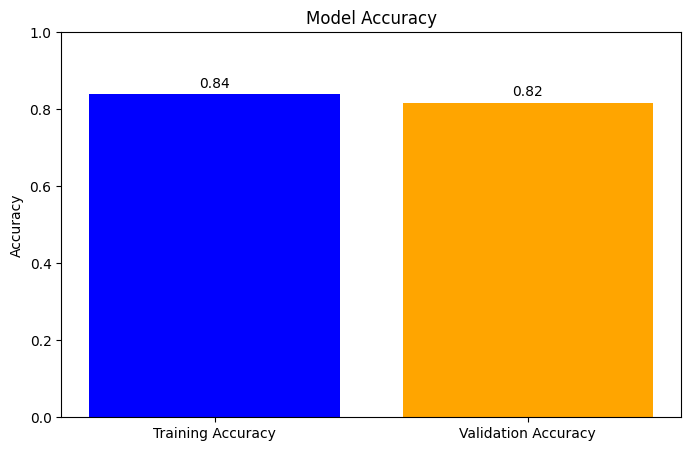

In [ ]:
# Assuming you have already built and trained your model as shown in previous steps

# Get the final accuracy values
final_train_accuracy = history.history['accuracy'][-1]
final_val_accuracy = history.history['val_accuracy'][-1]

# Create a bar plot for accuracy
labels = ['Training Accuracy', 'Validation Accuracy']
accuracy_values = [final_train_accuracy, final_val_accuracy]

plt.figure(figsize=(8, 5))
plt.bar(labels, accuracy_values, color=['blue', 'orange'])
plt.ylim(0, 1)  # Set the y-axis limits to show accuracy from 0 to 1
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

# Display the values on top of the bars
for i, v in enumerate(accuracy_values):
    plt.text(i, v + 0.01, f"{v:.2f}", ha='center', va='bottom')

plt.show()


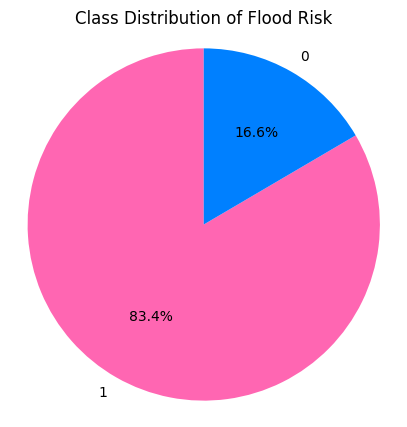

In [6]:
import matplotlib.pyplot as plt

# Assuming you have your 'Flood_Risk_Class' data in the 'data' DataFrame
if 'Flood_Risk_Class' in data.columns:
    class_distribution = data['Flood_Risk_Class'].value_counts()

    # Use the actual class labels directly from the index
    class_labels = class_distribution.index.tolist()

    # Define custom colors for each class (Updated)
    colors = ['#ff66b2', '#0080ff']  # Pink for 'Low', Blue for 'High'

    # Create a pie chart for class distribution
    plt.figure(figsize=(5, 5))
    plt.pie(class_distribution, labels=class_labels, autopct='%1.1f%%', startangle=90, colors=colors)
    plt.title('Class Distribution of Flood Risk')
    plt.axis('equal')  # Equal aspect ratio ensures that pie chart is circular.

    plt.show()
else:
    print("Error: 'Flood_Risk_Class' column not found in the dataset.")


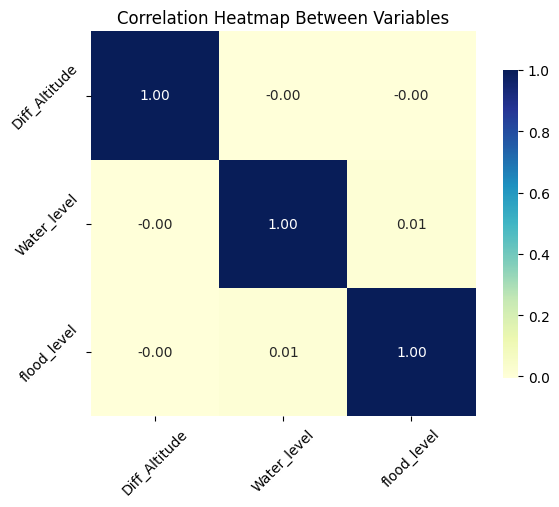

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Load your dataset (ensure to include this step)
df = pd.read_csv('flood_data.csv')

# Step 2: Calculate the correlation matrix for the relevant columns
try:
    correlation_matrix = df[['Diff_Altitude', 'Water_level', 'flood_level']].corr()
except KeyError as e:
    print(f"Error: {e}. Please check the column names.")

# Step 3: Create a heatmap with a different color palette
plt.figure(figsize=(7, 5))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='YlGnBu', square=True, cbar_kws={"shrink": .8})

# Adding titles and labels
plt.title('Correlation Heatmap Between Variables')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

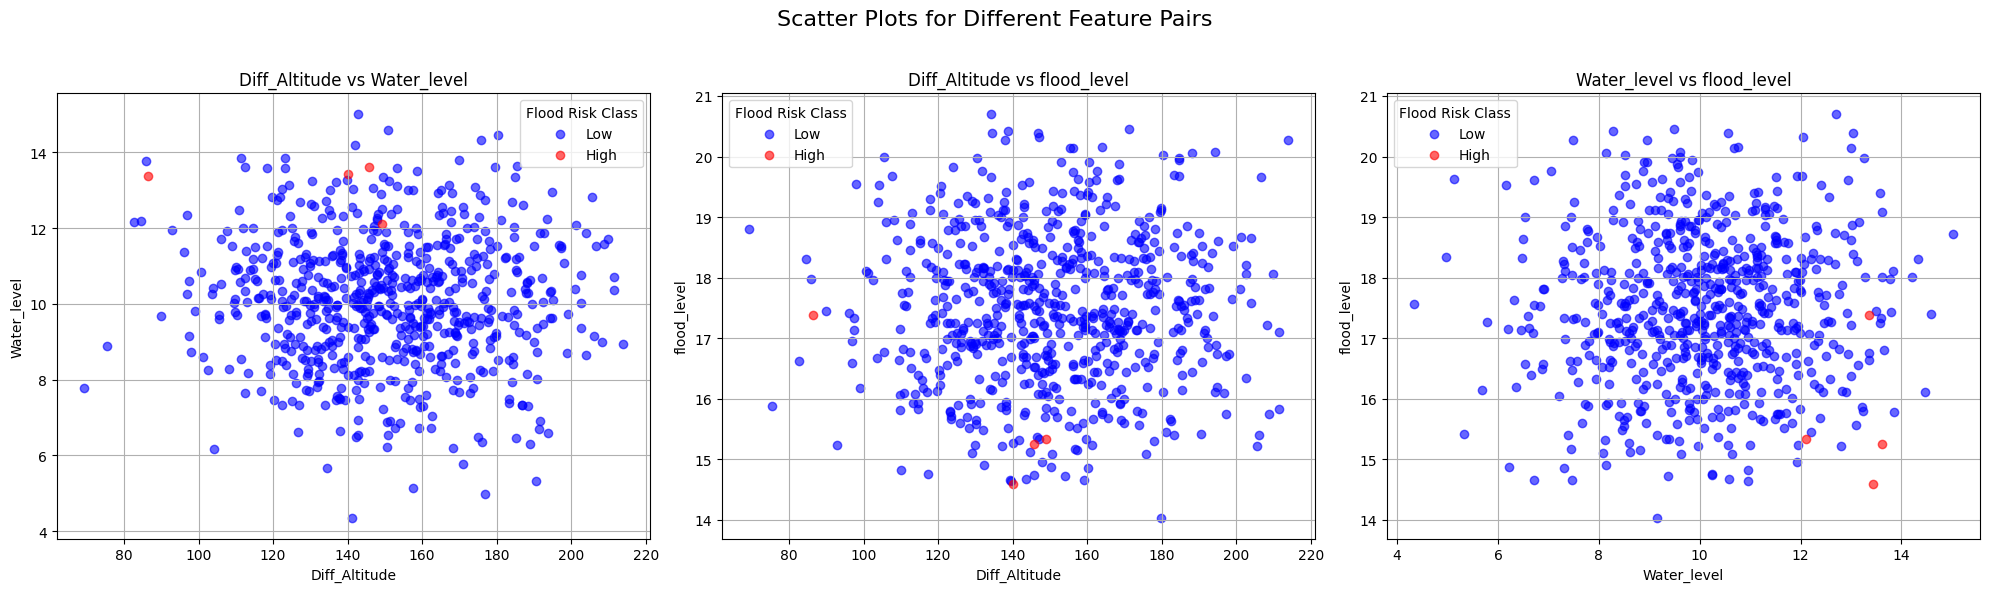

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset from the CSV file
file_path = 'flood_data_yearly_merged.csv'  # Replace with your CSV file path
df = pd.read_csv(file_path)

# Define color mapping for Flood_Risk_Class
colors = {'Low': 'blue', 'High': 'red'}

# List of column pairs for scatter plots
pairs = [
    ('Diff_Altitude', 'Water_level'),
    ('Diff_Altitude', 'flood_level'),
    ('Water_level', 'flood_level')
]

# Titles for each subplot
titles = [
    'Diff_Altitude vs Water_level',
    'Diff_Altitude vs flood_level',
    'Water_level vs flood_level'
]

# Plot each pair in a horizontal layout
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))
fig.suptitle('Scatter Plots for Different Feature Pairs', fontsize=16)

for (x_col, y_col), ax, title in zip(pairs, axs, titles):
    for risk_class in df['Flood_Risk_Class'].unique():
        subset = df[df['Flood_Risk_Class'] == risk_class]
        ax.scatter(subset[x_col], subset[y_col], color=colors[risk_class], label=risk_class, alpha=0.6)
    ax.set_title(title)
    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    ax.legend(title='Flood Risk Class')
    ax.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title
plt.show()


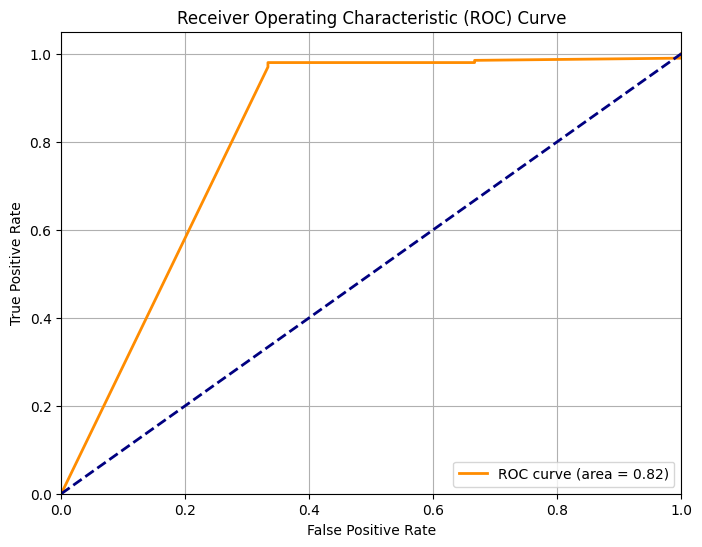

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelEncoder

# Load the dataset from the CSV file
file_path = 'flood_data_yearly_merged.csv'  # Replace with your CSV file path
df = pd.read_csv(file_path)

# Prepare features and target
X = df[['Diff_Altitude', 'Water_level', 'flood_level']]  # Use relevant features
y = df['Flood_Risk_Class']

# Encode the target variable
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)  # 0 for 'Low', 1 for 'High'

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a Random Forest Classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predict probabilities for the positive class (High risk)
y_prob = clf.predict_proba(X_test)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
